# Banana Ripeness Notebook


GPU Setup (clean logs + working GPU)


In [11]:
import os

# Disable XLA to prevent libdevice and ptxas warnings
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

# Reduce TensorFlow log noise (0 = all, 3 = only critical errors)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("GPU setup done. XLA disabled and logs cleaned.")


GPU setup done. XLA disabled and logs cleaned.


Loading Dataset

In [12]:
from pathlib import Path

dataset_root = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied")

train_path = dataset_root / "train"
test_path  = dataset_root / "test"

# Existence checks (prints are screenshot-friendly)
print("\nChecking dataset folders...")
if not dataset_root.exists():
    raise FileNotFoundError(f"Dataset root not found: {dataset_root}")
if not train_path.exists() or not test_path.exists():
    raise FileNotFoundError(f"'train/' or 'test/' not found inside: {dataset_root}")

# List class folders (ignore hidden)
train_classes = sorted([d.name for d in train_path.iterdir() if d.is_dir() and not d.name.startswith('.')])
test_classes  = sorted([d.name for d in test_path.iterdir() if d.is_dir() and not d.name.startswith('.')])

print("Dataset root:", dataset_root)
print("Train folder:", train_path.resolve())
print("Test  folder:", test_path.resolve())
print("Classes (train):", train_classes)
print("Classes (test) :", test_classes)



Checking dataset folders...
Dataset root: /home/bunnysingh/Documents/Ml/bannna_clasffied
Train folder: /home/bunnysingh/Documents/Ml/bannna_clasffied/train
Test  folder: /home/bunnysingh/Documents/Ml/bannna_clasffied/test
Classes (train): ['Half-ripened', 'Overripe', 'Ripe', 'Unripe']
Classes (test) : ['Half-ripened', 'Overripe', 'Ripe', 'Unripe']


Preprocessing (load, resize, normalize, split, pipeline)

In [26]:
# ---------------- Tab 2 ----------------
# Load images (CPU pipeline), detect classes, normalize and prepare train/val/test datasets.

import tensorflow as tf
from pathlib import Path
import math

# Paths reused from Tab 1
train_dir = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied/train")
test_dir  = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied/test")

# Settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.15
AUTOTUNE = tf.data.AUTOTUNE

print("Loading datasets (input pipeline runs on CPU) ...")

# Load datasets on CPU (prevents dataset-GPU shuffle CUDA errors)
with tf.device("/CPU:0"):
    raw_train = tf.keras.utils.image_dataset_from_directory(
        str(train_dir),
        labels="inferred",
        label_mode="categorical",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42
    )

    raw_test = tf.keras.utils.image_dataset_from_directory(
        str(test_dir),
        labels="inferred",
        label_mode="categorical",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

# class names (Keras folder order)
class_names = raw_train.class_names

# show quick summary (screenshot-friendly)
total_train_images = sum(1 for _ in raw_train.unbatch())
val_count = int(total_train_images * VAL_SPLIT)
train_count = total_train_images - val_count

print("\nDetected classes:", class_names)
print("Total train images:", total_train_images)
print("Train after split:", train_count, "Validation:", val_count)
print("Test images (approx):", sum(1 for _ in raw_test.unbatch()))

# Create deterministic validation split
unbatched = raw_train.unbatch()
val_unbatched = unbatched.take(val_count)
train_unbatched = unbatched.skip(val_count)

train_raw = train_unbatched.batch(BATCH_SIZE)
val_raw   = val_unbatched.batch(BATCH_SIZE)

# Normalize function
def normalize_fn(x, y):
    return tf.cast(x, tf.float32) / 255.0, y

# prepare pipelines (prefetch for performance)
train_ds = train_raw.map(normalize_fn, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
val_ds   = val_raw.map(normalize_fn,   num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds  = raw_test.map(normalize_fn,  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

# export useful variables (for report / next tabs)
steps_per_epoch = math.ceil(train_count / BATCH_SIZE) if train_count>0 else 0
validation_steps = math.ceil(val_count / BATCH_SIZE) if val_count>0 else 0
test_steps = math.ceil(sum(1 for _ in raw_test.unbatch()) / BATCH_SIZE)

print("\nPipeline ready: train_ds, val_ds, test_ds available.")
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps, "Test steps:", test_steps)


Loading datasets (input pipeline runs on CPU) ...
Found 1490 files belonging to 4 classes.
Found 375 files belonging to 4 classes.

Detected classes: ['Half-ripened', 'Overripe', 'Ripe', 'Unripe']
Total train images: 1490
Train after split: 1267 Validation: 223
Test images (approx): 375

Pipeline ready: train_ds, val_ds, test_ds available.
Steps per epoch: 40 Validation steps: 7 Test steps: 12


Exploratory Data Analysis (EDA)

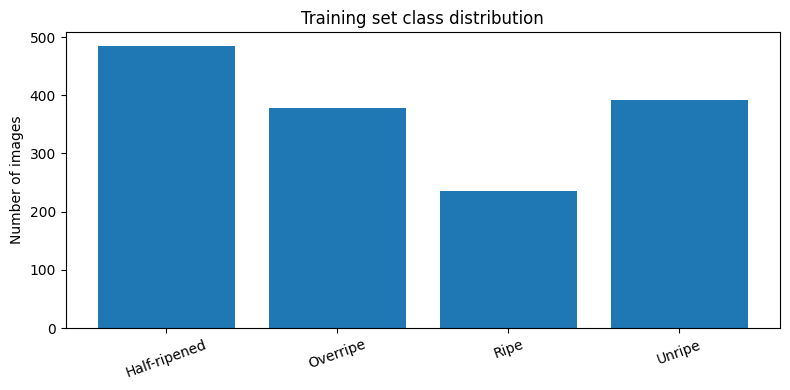


Sample images (one per non-empty class):


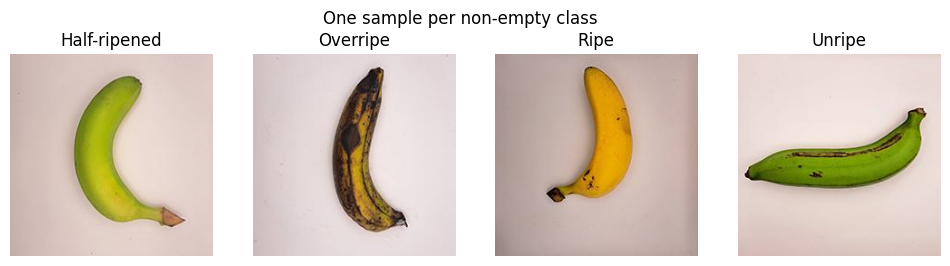


Pixel stats (sample):
 Sample images used: 300
 Pixel mean (RGB): [0.9157, 0.8659, 0.7353]
 Pixel var  (RGB): [0.020117, 0.016703, 0.065459]


In [14]:

# Exploratory Data Analysis — plots & sample images shown inline (screenshot-ready)

%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

train_dir = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied/train")

# 1) Class distribution (folder counts)
counts = {c: len(list((train_dir / c).glob("*"))) for c in class_names}
plt.figure(figsize=(8,4))
plt.bar(counts.keys(), counts.values())
plt.title("Training set class distribution")
plt.ylabel("Number of images")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# 2) Sample images (skip empty folders; prints warnings)
print("\nSample images (one per non-empty class):")
nonempty = [c for c in class_names if len(list((train_dir / c).glob("*"))) > 0]
if len(nonempty) == 0:
    print("No images found in training folders.")
else:
    plt.figure(figsize=(3*len(nonempty), 3))
    for i, c in enumerate(nonempty):
        imgs = sorted(list((train_dir / c).glob("*")))
        try:
            img = Image.open(imgs[0]).convert("RGB").resize((224,224))
        except Exception as e:
            print(f"Cannot open image {imgs[0].name} in class {c}: {e}")
            continue
        plt.subplot(1, len(nonempty), i+1)
        plt.imshow(img)
        plt.title(c)
        plt.axis("off")
    plt.suptitle("One sample per non-empty class")
    plt.show()

# 3) Pixel statistics (small sample for speed)
def pixel_stats(folder, class_list, sample_limit=200):
    arrs = []
    cnt = 0
    for cname in class_list:
        p = Path(folder) / cname
        for f in sorted(p.glob("*")):
            try:
                im = np.array(Image.open(f).resize((224,224))).astype("float32") / 255.0
            except Exception:
                continue
            arrs.append(im)
            cnt += 1
            if cnt >= sample_limit:
                break
        if cnt >= sample_limit:
            break
    if not arrs:
        return None, None, 0
    stacked = np.stack(arrs, axis=0)
    return stacked.mean(axis=(0,1,2)).tolist(), stacked.var(axis=(0,1,2)).tolist(), cnt

mean_rgb, var_rgb, n = pixel_stats(train_dir, class_names, sample_limit=300)
print("\nPixel stats (sample):")
if n:
    print(" Sample images used:", n)
    print(" Pixel mean (RGB):", [round(x,4) for x in mean_rgb])
    print(" Pixel var  (RGB):", [round(x,6) for x in var_rgb])
else:
    print(" No readable images for pixel stats.")


Data augmentation, CNN model, training, training plots and test evaluation


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

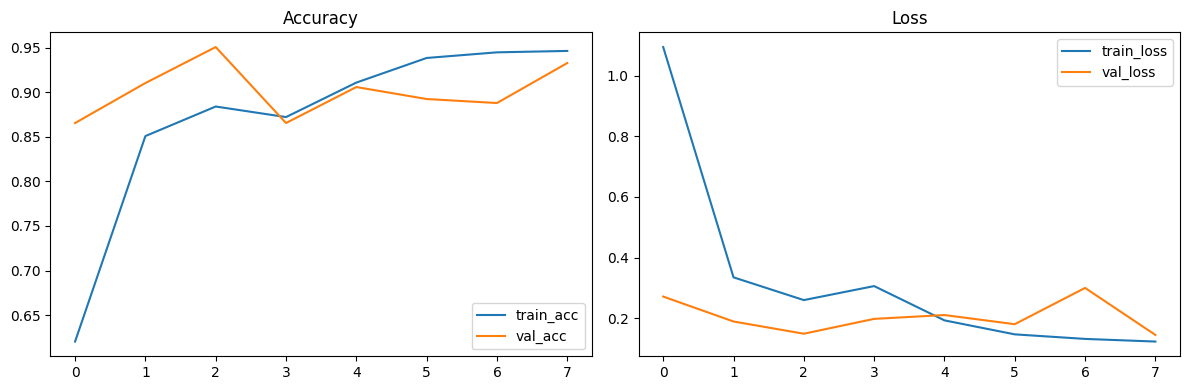

12/12 [==============================] - 2s 131ms/step - loss: 0.1045 - accuracy: 0.9413

Test loss: 0.1045   |   Test accuracy: 0.9413


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Data augmentation (applied in-model for reproducibility)
augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.08),
], name="augmentation")

# Model architecture (adaptable to number of classes)
model = keras.Sequential([
    layers.Input(shape=(224,224,3)),
    augmentation,
    layers.Rescaling(1./1.0),  # images already normalized in dataset; keep as-pass-through
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# Training (short run for demo; increase epochs for final model)
EPOCHS = 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest loss: {test_loss:.4f}   |   Test accuracy: {test_acc:.4f}")


## Tab 5 — Model Evaluation (Confusion Matrix, Classification Report & Misclassified Images)

In this section, we evaluate the performance of the trained banana ripeness classifier using:
- Confusion Matrix
- Precision, Recall, F1-Scores (Classification Report)
- Visual inspection of misclassified examples

These results help us understand which classes the model struggles with and validate the quality of predictions.


 OVERALL METRICS 
Accuracy            : 0.9413
Balanced Accuracy   : 0.9090
Cohen's Kappa       : 0.9197

 AVERAGE METRICS 
Macro Precision     : 0.9522
Macro Recall        : 0.9090
Macro F1 Score      : 0.9187
Micro F1 Score      : 0.9413
Weighted F1 Score   : 0.9381

PER-CLASS METRICS


,Class,Precision,Recall,F1-Score,Support
0,Half-ripened,1.000,0.9918,0.9959,122
1,Overripe,0.819,1.0000,0.9005,95
2,Ripe,1.000,0.6441,0.7835,59
3,Unripe,0.990,1.0000,0.9950,99



 CLASSIFICATION REPORT 

              precision    recall  f1-score   support

Half-ripened     1.0000    0.9918    0.9959       122
    Overripe     0.8190    1.0000    0.9005        95
        Ripe     1.0000    0.6441    0.7835        59
      Unripe     0.9900    1.0000    0.9950        99

    accuracy                         0.9413       375
   macro avg     0.9522    0.9090    0.9187       375
weighted avg     0.9515    0.9413    0.9381       375



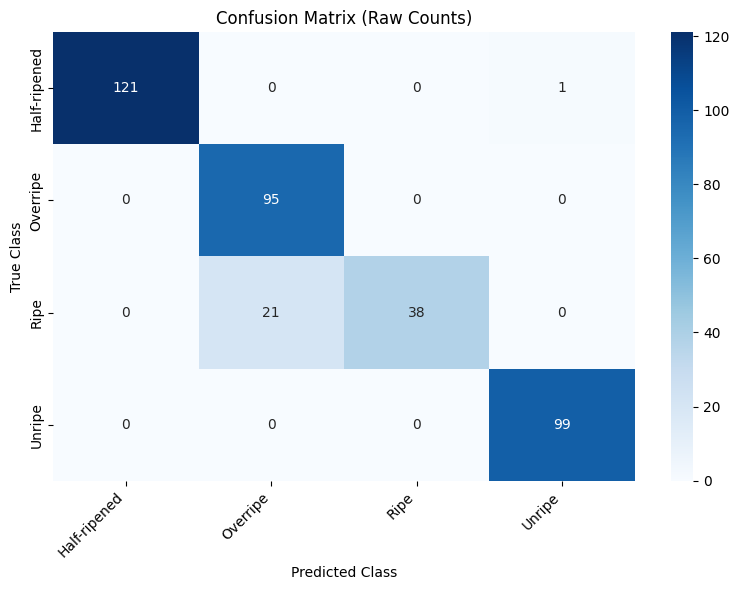

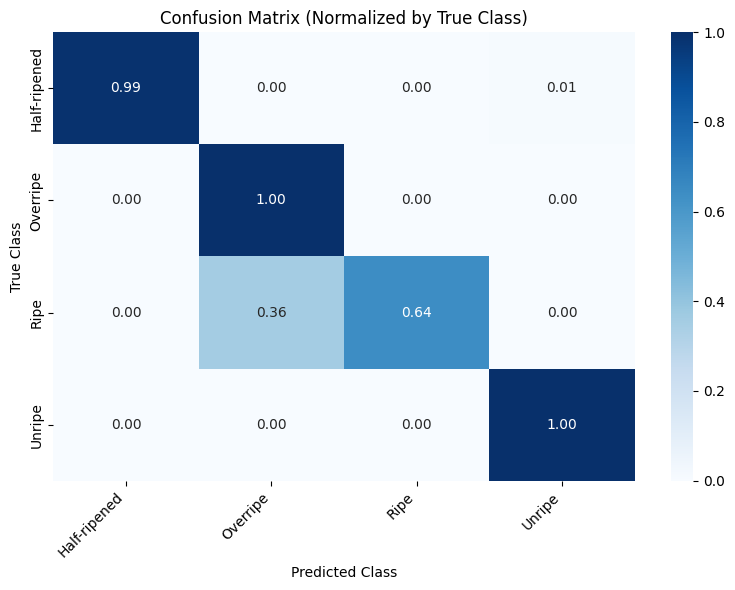


TAB 5 COMPLETE — All metrics displayed clearly.



In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, cohen_kappa_score,
    precision_recall_fscore_support, classification_report,
    confusion_matrix
)


# Step 1: Extract predictions from test_ds

y_true = []
y_pred = []

for batch_x, batch_y in test_ds:
    probs = model.predict(batch_x, verbose=0)
    preds = np.argmax(probs, axis=1)
    trues = np.argmax(batch_y.numpy(), axis=1)

    y_true.extend(trues.tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

num_classes = len(class_names)

# Step 2: Main Metrics

acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

prec, rec, f1, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=list(range(num_classes)), zero_division=0
)

print(" OVERALL METRICS ")
print(f"Accuracy            : {acc:.4f}")
print(f"Balanced Accuracy   : {bal_acc:.4f}")
print(f"Cohen's Kappa       : {kappa:.4f}")
print()

print(" AVERAGE METRICS ")
print(f"Macro Precision     : {np.mean(prec):.4f}")
print(f"Macro Recall        : {np.mean(rec):.4f}")
print(f"Macro F1 Score      : {np.mean(f1):.4f}")
print(f"Micro F1 Score      : {precision_recall_fscore_support(y_true, y_pred, average='micro')[2]:.4f}")
print(f"Weighted F1 Score   : {precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]:.4f}")
print()


# Step 3: Detailed per-class table

df = pd.DataFrame({
    "Class": class_names,
    "Precision": np.round(prec, 4),
    "Recall": np.round(rec, 4),
    "F1-Score": np.round(f1, 4),
    "Support": sup
})

print("PER-CLASS METRICS")
display(df)


# Step 4: Full text classification report


print("\n CLASSIFICATION REPORT \n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0
))


# Step 5: Confusion Matrix (raw)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Step 6: Normalized Confusion Matrix


cm_norm = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-9)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\nTAB 5 COMPLETE — All metrics displayed clearly.\n")


 EXPORT MODELS

In [18]:


import os
import json
import numpy as np
from pathlib import Path
from PIL import Image
import tensorflow as tf

#  Disable all TF logs / warnings

os.environ["CUDA_VISIBLE_DEVICES"] = ""          # prevent GPU probing
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"         # hide TF INFO/WARN
tf.get_logger().setLevel("ERROR")

# -------------------------------
#  Export Directory
# -------------------------------
OUT_DIR = Path("exported_models")
OUT_DIR.mkdir(exist_ok=True)

keras_h5        = OUT_DIR / "banana_model.h5"
saved_model_dir = OUT_DIR / "banana_saved_model"
tflite_fp32     = OUT_DIR / "banana_model_fp32.tflite"
tflite_dyn      = OUT_DIR / "banana_model_dynamic.tflite"
class_map_file  = OUT_DIR / "class_map.json"

print("• Export directory ready:", OUT_DIR)


# 1) Save Keras H5

model.save(str(keras_h5), include_optimizer=False)
print("✔ Saved:", keras_h5)


# 2) Save TensorFlow SavedModel

tf.keras.models.save_model(
    model, str(saved_model_dir),
    include_optimizer=False, save_format="tf"
)
print("✔ Saved:", saved_model_dir)


# 3) Save class mapping for app

try:
    labels = train_class_names
except:
    labels = class_names

with open(class_map_file, "w") as f:
    json.dump({str(i): labels[i] for i in range(len(labels))}, f, indent=2)

print("✔ Saved labels:", class_map_file)


# 4) Convert to TFLite (Float32)

converter = tf.lite.TFLiteConverter.from_saved_model(str(saved_model_dir))
tflite_fp32_model = converter.convert()

with open(tflite_fp32, "wb") as f:
    f.write(tflite_fp32_model)

print("✔ Saved FP32 TFLite:", tflite_fp32)

# 5) Convert to TFLite (Dynamic Quantization)

converter = tf.lite.TFLiteConverter.from_saved_model(str(saved_model_dir))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_dyn_model = converter.convert()

with open(tflite_dyn, "wb") as f:
    f.write(tflite_dyn_model)

print("✔ Saved Dynamic-Quantized TFLite:", tflite_dyn)


# 6) Export Summary

print("\nEXPORT SUMMARY ")
print(f"H5 size:               {keras_h5.stat().st_size/1024:.1f} KB")
print(f"SavedModel size:        {sum(f.stat().st_size for f in saved_model_dir.rglob('*'))/1024:.1f} KB")
print(f"TFLite FP32 size:       {tflite_fp32.stat().st_size/1024:.1f} KB")
print(f"TFLite Dynamic size:    {tflite_dyn.stat().st_size/1024:.1f} KB")

#                   SAFE DEMO INFERENCE (NO WARNINGS)


TEST_DIR = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied/test")
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"}

def find_sample(folder):
    """Find first real image in test directory."""
    for sub in sorted(folder.iterdir()):
        if sub.is_dir():
            for f in sorted(sub.iterdir()):
                if f.suffix.lower() in IMG_EXTS:
                    return f
    for f in folder.rglob("*"):
        if f.is_file() and f.suffix.lower() in IMG_EXTS:
            return f
    return None

IMG_SAMPLE = find_sample(TEST_DIR)

if IMG_SAMPLE is None:
    print("\n⚠ No valid image found for demo.")
else:
    print("\n✔ Demo image selected:", IMG_SAMPLE)

    # Load image → preprocess
    def load_for_model(path, size=(224,224)):
        img = Image.open(path).convert("RGB").resize(size)
        arr = np.array(img).astype("float32") / 255.0
        return np.expand_dims(arr, axis=0)

    x = load_for_model(IMG_SAMPLE)

    print("\nDEMO INFERENCE ")

    # Keras H
    m = tf.keras.models.load_model(str(keras_h5))
    probs = m.predict(x, verbose=0)[0]
    pred = np.argmax(probs)
    print(f"Keras H5 → {labels[pred]} ({float(np.max(probs)):.3f})")

    #  SavedModel 
    sm = tf.keras.models.load_model(str(saved_model_dir))
    probs2 = sm.predict(x, verbose=0)[0]
    pred2 = np.argmax(probs2)
    print(f"SavedModel → {labels[pred2]} ({float(np.max(probs2)):.3f})")

    #  TFLite FP32 
    interpreter = tf.lite.Interpreter(model_path=str(tflite_fp32))
    interpreter.allocate_tensors()
    i_idx = interpreter.get_input_details()[0]['index']
    o_idx = interpreter.get_output_details()[0]['index']
    interpreter.set_tensor(i_idx, x.astype(np.float32))
    interpreter.invoke()
    out = interpreter.get_tensor(o_idx)[0]
    print(f"TFLite FP32 → {labels[np.argmax(out)]} ({float(np.max(out)):.3f})")

    # TFLite Dynamic
    interpreter2 = tf.lite.Interpreter(model_path=str(tflite_dyn))
    interpreter2.allocate_tensors()
    i2 = interpreter2.get_input_details()[0]['index']
    o2 = interpreter2.get_output_details()[0]['index']
    interpreter2.set_tensor(i2, x.astype(np.float32))
    interpreter2.invoke()
    out2 = interpreter2.get_tensor(o2)[0]
    print(f"TFLite Dynamic → {labels[np.argmax(out2)]} ({float(np.max(out2)):.3f})")



• Export directory ready: exported_models
✔ Saved: exported_models/banana_model.h5


✔ Saved: exported_models/banana_saved_model
✔ Saved labels: exported_models/class_map.json
✔ Saved FP32 TFLite: exported_models/banana_model_fp32.tflite
✔ Saved Dynamic-Quantized TFLite: exported_models/banana_model_dynamic.tflite

EXPORT SUMMARY 
H5 size:               50574.9 KB
SavedModel size:        50973.2 KB
TFLite FP32 size:       50546.8 KB
TFLite Dynamic size:    12647.2 KB

✔ Demo image selected: /home/bunnysingh/Documents/Ml/bannna_clasffied/test/Half-ripened/setengah-matang_005.jpg

DEMO INFERENCE 
Keras H5 → Half-ripened (1.000)
SavedModel → Half-ripened (1.000)
TFLite FP32 → Half-ripened (1.000)
TFLite Dynamic → Ripe (1.000)


In [19]:
## Model consistency & disagreement check 


Found 375 test images across folders: ['Ripe', 'Overripe', 'Unripe', 'Half-ripened']

=== MODEL ACCURACY ===
H5 vs True:            0.9333
SavedModel vs True:     0.9333
TFLite FP32 vs True:    0.9333
TFLite Dynamic vs True: 0.1573

Confusion matrices saved.

Total mismatches (H5 vs Dynamic): 340


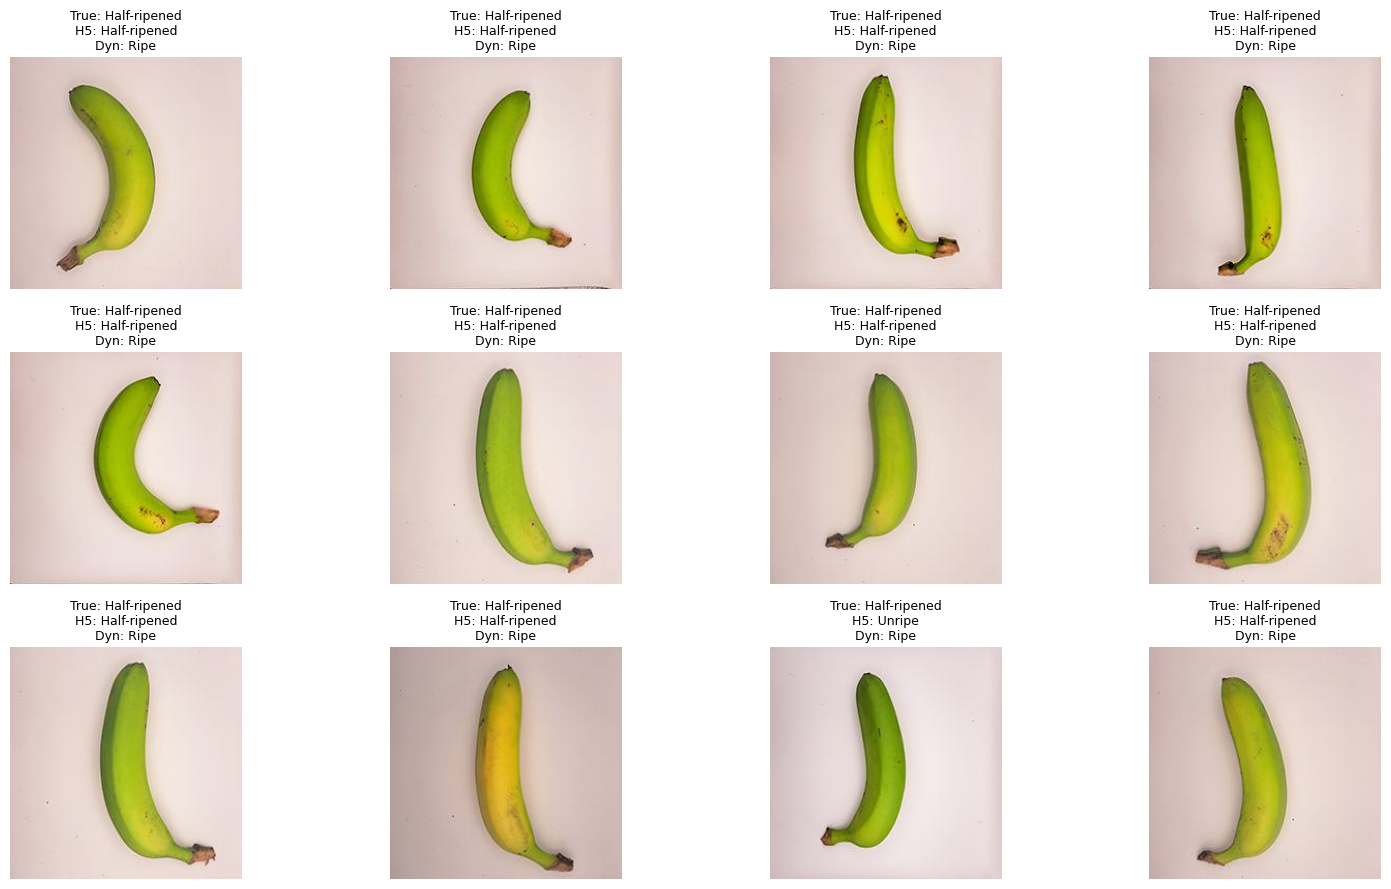


Tab 7 completed successfully.


In [22]:
import os, json, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from math import ceil

# -------------------------------------------------------
# QUIET LOGS
# -------------------------------------------------------
os.environ["CUDA_VISIBLE_DEVICES"] = ""           # Force CPU (no CUDA warnings)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel("ERROR")

# -------------------------------------------------------
# PATHS
# -------------------------------------------------------
ROOT = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied")
TEST_DIR = ROOT / "test"

EXPORT_DIR = Path("exported_models")
H5_PATH = EXPORT_DIR / "banana_model.h5"
SAVED_DIR = EXPORT_DIR / "banana_saved_model"
TFLITE_FP32 = EXPORT_DIR / "banana_model_fp32.tflite"
TFLITE_DYN  = EXPORT_DIR / "banana_model_dynamic.tflite"
CLASS_MAP = EXPORT_DIR / "class_map.json"

IMG_SIZE = (224,224)
BATCH = 32

# -------------------------------------------------------
# LOAD LABEL MAP
# -------------------------------------------------------
if CLASS_MAP.exists():
    with open(CLASS_MAP, "r") as f:
        label_map = json.load(f)
    labels = [label_map[str(i)] for i in range(len(label_map))]
else:
    labels = class_names   # Fallback
num_classes = len(labels)

# -------------------------------------------------------
# HELPERS
# -------------------------------------------------------
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"}

def is_image(p):
    return p.suffix.lower() in IMG_EXTS

def safe_open(path, size=IMG_SIZE):
    try:
        im = Image.open(path).convert("RGB").resize(size)
        arr = np.array(im).astype("float32") / 255.0
        return np.expand_dims(arr, axis=0)
    except:
        return None

# -------------------------------------------------------
# SCAN TEST DATASET
# -------------------------------------------------------
test_files = []
test_true = []

class_folders = [p.name for p in TEST_DIR.iterdir() if p.is_dir() and not p.name.startswith('.')]

for cname in sorted(class_folders):
    folder = TEST_DIR / cname
    for f in sorted(folder.iterdir()):
        if f.is_file() and is_image(f):
            test_files.append(f)

            # Match folder name with label index
            if cname in labels:
                test_true.append(labels.index(cname))
            else:
                test_true.append(-1)

if len(test_files) == 0:
    raise RuntimeError("No test images found. Remove '.venv' folders inside test/.")

N = len(test_files)
print(f"Found {N} test images across folders: {class_folders}")

# -------------------------------------------------------
# LOAD MODELS
# -------------------------------------------------------
keras_m = tf.keras.models.load_model(str(H5_PATH))
saved_m = tf.keras.models.load_model(str(SAVED_DIR))

# Load TFLite Models
def load_tflite(path):
    interpreter = tf.lite.Interpreter(model_path=str(path))
    interpreter.allocate_tensors()
    inp = interpreter.get_input_details()[0]['index']
    out = interpreter.get_output_details()[0]['index']
    return interpreter, inp, out

it_fp32, in_fp32, out_fp32 = load_tflite(TFLITE_FP32)
it_dyn,  in_dyn,  out_dyn  = load_tflite(TFLITE_DYN)

# -------------------------------------------------------
# PREDICT IN BATCHES
# -------------------------------------------------------
all_preds_h5 = []
all_preds_saved = []
all_preds_fp32 = []
all_preds_dyn = []
valid_true = []

for i in range(0, N, BATCH):
    batch_files = test_files[i:i+BATCH]
    batch_imgs = []
    batch_labels = []

    for f, t in zip(batch_files, test_true[i:i+BATCH]):
        x = safe_open(f)
        if x is None: continue
        batch_imgs.append(x[0])
        batch_labels.append(t)

    if len(batch_imgs) == 0:
        continue

    X = np.stack(batch_imgs, axis=0)

    # H5
    preds_h5 = np.argmax(keras_m.predict(X, verbose=0), axis=1)

    # SavedModel
    preds_saved = np.argmax(saved_m.predict(X, verbose=0), axis=1)

    # TFLite FP32
    it_fp32.resize_tensor_input(in_fp32, [len(X), *X.shape[1:]], strict=True)
    it_fp32.allocate_tensors()
    it_fp32.set_tensor(in_fp32, X.astype(np.float32))
    it_fp32.invoke()
    preds_fp32 = np.argmax(it_fp32.get_tensor(out_fp32), axis=1)

    # TFLite Dynamic Quantized
    it_dyn.resize_tensor_input(in_dyn, [len(X), *X.shape[1:]], strict=True)
    it_dyn.allocate_tensors()
    it_dyn.set_tensor(in_dyn, X.astype(np.float32))
    it_dyn.invoke()
    preds_dyn = np.argmax(it_dyn.get_tensor(out_dyn), axis=1)

    all_preds_h5.extend(preds_h5.tolist())
    all_preds_saved.extend(preds_saved.tolist())
    all_preds_fp32.extend(preds_fp32.tolist())
    all_preds_dyn.extend(preds_dyn.tolist())
    valid_true.extend(batch_labels)

# Convert to arrays
y_true = np.array(valid_true)
h5_p   = np.array(all_preds_h5)
sv_p   = np.array(all_preds_saved)
fp32_p = np.array(all_preds_fp32)
dyn_p  = np.array(all_preds_dyn)

# -------------------------------------------------------
# ACCURACY & AGREEMENT
# -------------------------------------------------------
def acc(a,b): return float((a==b).mean())

print("\n=== MODEL ACCURACY ===")
print(f"H5 vs True:            {accuracy_score(y_true, h5_p):.4f}")
print(f"SavedModel vs True:     {accuracy_score(y_true, sv_p):.4f}")
print(f"TFLite FP32 vs True:    {accuracy_score(y_true, fp32_p):.4f}")
print(f"TFLite Dynamic vs True: {accuracy_score(y_true, dyn_p):.4f}")

# -------------------------------------------------------
# CONFUSION MATRICES
# -------------------------------------------------------
cm_h5  = confusion_matrix(y_true, h5_p)
cm_dyn = confusion_matrix(y_true, dyn_p)

np.savetxt(EXPORT_DIR / "confusion_h5_vs_true.csv", cm_h5, delimiter=",", fmt="%d")
np.savetxt(EXPORT_DIR / "confusion_dyn_vs_true.csv", cm_dyn, delimiter=",", fmt="%d")

print("\nConfusion matrices saved.")

# -------------------------------------------------------
# DISAGREEMENT ANALYSIS
# -------------------------------------------------------
disagree = np.where(h5_p != dyn_p)[0]
print(f"\nTotal mismatches (H5 vs Dynamic): {len(disagree)}")

# -------------------------------------------------------
# VISUALIZE UP TO 12 WRONG PREDICTIONS
# -------------------------------------------------------
if len(disagree) > 0:
    max_show = min(12, len(disagree))
    cols = 4
    rows = ceil(max_show / cols)
    plt.figure(figsize=(4*cols, 3*rows))

    for i, idx in enumerate(disagree[:max_show]):
        img_path = test_files[idx]
        img = Image.open(img_path).convert("RGB").resize((224,224))

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(
            f"True: {labels[y_true[idx]]}\nH5: {labels[h5_p[idx]]}\nDyn: {labels[dyn_p[idx]]}", 
            fontsize=9
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

print("\nTab 7 completed successfully.")


## Model consistency check (easy output + logs

=== Tab 7 — Model consistency check started ===
Loaded 4 labels: ['Half-ripened', 'Overripe', 'Ripe', 'Unripe']
Found 375 test images in /home/bunnysingh/Documents/Ml/bannna_clasffied/test
Models loaded (None means missing):
 - H5: True
 - SavedModel: True
 - TFLite FP32: True
 - TFLite Dyn: True
Saved per-image predictions to: exported_models/prediction_comparison.csv
Accuracy of h5 vs true: 0.9333
Accuracy of sm vs true: 0.9333
Accuracy of tflite_fp32 vs true: 0.9333
Accuracy of tflite_dyn vs true: 0.1573
Found 8 disagreement examples (showing up to 8).


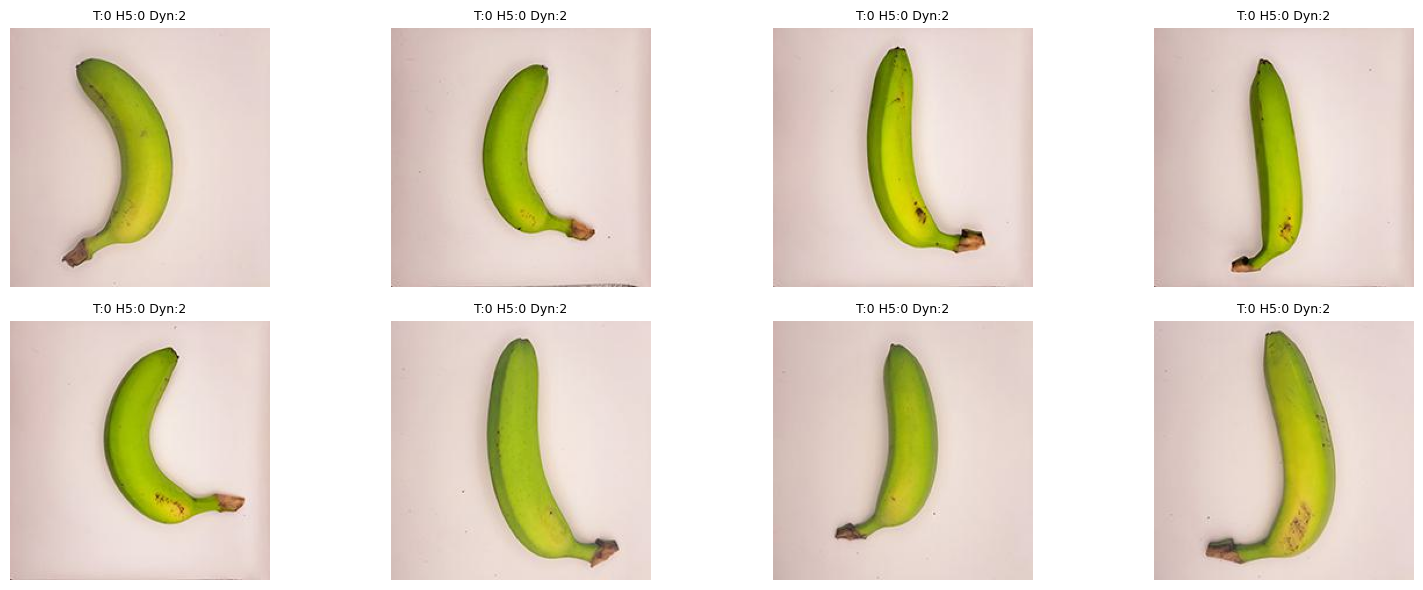

=== Tab 7 complete ===


In [23]:

# Paste and run after Tab 6 (exports exist).
import os, json, traceback
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

ROOT = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied")   # change if needed
TEST_DIR = ROOT / "test"
EXPORT_DIR = Path("exported_models")
LOG_FILE = EXPORT_DIR / "run_logs.txt"
EXPORT_DIR.mkdir(exist_ok=True, parents=True)

def log(msg):
    print(msg)
    with open(LOG_FILE, "a") as f:
        f.write(msg + "\n")

try:
    log("=== Tab 7 — Model consistency check started ===")

    # load class map
    class_map_file = EXPORT_DIR / "class_map.json"
    if not class_map_file.exists():
        raise FileNotFoundError(f"class_map.json not found in {EXPORT_DIR}")
    with open(class_map_file) as f:
        cmap = json.load(f)
    labels = [cmap[str(i)] for i in range(len(cmap))]
    num_classes = len(labels)
    log(f"Loaded {len(labels)} labels: {labels}")

    # find test images (ignore hidden and .venv)
    img_exts = {".jpg",".jpeg",".png",".bmp",".tiff",".webp",".gif"}
    files = []
    true_idxs = []
    for sub in sorted(TEST_DIR.iterdir()):
        if not sub.is_dir() or sub.name.startswith('.'):
            continue
        for f in sorted(sub.iterdir()):
            if f.is_file() and f.suffix.lower() in img_exts:
                files.append(f)
                # map subfolder name to index (if found)
                true_idxs.append(labels.index(sub.name) if sub.name in labels else -1)
    if len(files)==0:
        raise RuntimeError("No test images found — check TEST_DIR path and remove .venv folder from test/")

    log(f"Found {len(files)} test images in {TEST_DIR}")

    # load models (H5 and SavedModel) and TFLite if available
    h5_path = EXPORT_DIR / "banana_model.h5"
    sm_dir   = EXPORT_DIR / "banana_saved_model"
    tflite_fp32 = EXPORT_DIR / "banana_model_fp32.tflite"
    tflite_dyn  = EXPORT_DIR / "banana_model_dynamic.tflite"

    h5_model = tf.keras.models.load_model(str(h5_path)) if h5_path.exists() else None
    sm_model = tf.keras.models.load_model(str(sm_dir)) if sm_dir.exists() else None

    def load_tflite(path):
        it = tf.lite.Interpreter(model_path=str(path))
        it.allocate_tensors()
        inp = it.get_input_details()[0]['index']
        out = it.get_output_details()[0]['index']
        return it, inp, out

    tflite_fp32_obj = load_tflite(tflite_fp32) if tflite_fp32.exists() else None
    tflite_dyn_obj  = load_tflite(tflite_dyn)  if tflite_dyn.exists()  else None

    log("Models loaded (None means missing):")
    log(f" - H5: {h5_model is not None}")
    log(f" - SavedModel: {sm_model is not None}")
    log(f" - TFLite FP32: {tflite_fp32_obj is not None}")
    log(f" - TFLite Dyn: {tflite_dyn_obj is not None}")

    # helpers
    def open_img_as_array(p, size=(224,224)):
        im = Image.open(p).convert("RGB").resize(size)
        arr = np.array(im).astype("float32")/255.0
        return arr

    def predict_tflite(it_tuple, arr):
        it, inp, out = it_tuple
        x = np.expand_dims(arr,0).astype(np.float32)
        try:
            it.resize_tensor_input(it.get_input_details()[0]['index'], x.shape, strict=False)
            it.allocate_tensors()
        except Exception:
            pass
        it.set_tensor(inp, x)
        it.invoke()
        outt = it.get_tensor(out)
        # interpret
        if outt.ndim==2 and outt.shape[1] >= num_classes:
            probs = outt[0,:num_classes]
        else:
            probs = outt.flatten()[:num_classes]
        return np.argmax(probs), float(np.max(probs))

    # run predictions in batches for speed
    BATCH = 32
    all_rows = []
    for i in range(0, len(files), BATCH):
        batch = files[i:i+BATCH]
        X = np.stack([open_img_as_array(p) for p in batch], axis=0)
        # H5 preds
        if h5_model:
            p_h5 = np.argmax(h5_model.predict(X, verbose=0), axis=1)
        else:
            p_h5 = [-1]*len(batch)
        # SavedModel preds
        if sm_model:
            p_sm = np.argmax(sm_model.predict(X, verbose=0), axis=1)
        else:
            p_sm = [-1]*len(batch)
        # tflite preds (fp32)
        p_fp32, conf_fp32 = [], []
        if tflite_fp32_obj:
            for arr in X:
                idx, conf = predict_tflite(tflite_fp32_obj, arr)
                p_fp32.append(idx); conf_fp32.append(conf)
        else:
            p_fp32 = [-1]*len(batch); conf_fp32=[0.0]*len(batch)
        # tflite dyn
        p_dyn, conf_dyn = [], []
        if tflite_dyn_obj:
            for arr in X:
                idx, conf = predict_tflite(tflite_dyn_obj, arr)
                p_dyn.append(idx); conf_dyn.append(conf)
        else:
            p_dyn = [-1]*len(batch); conf_dyn=[0.0]*len(batch)

        for j, p in enumerate(batch):
            row = {
                "file": str(p),
                "true_idx": true_idxs[i+j],
                "h5": int(p_h5[j]) if h5_model else -1,
                "sm": int(p_sm[j]) if sm_model else -1,
                "tflite_fp32": int(p_fp32[j]) if tflite_fp32_obj else -1,
                "tflite_dyn": int(p_dyn[j]) if tflite_dyn_obj else -1,
                "tflite_fp32_conf": float(conf_fp32[j]) if tflite_fp32_obj else 0.0,
                "tflite_dyn_conf": float(conf_dyn[j]) if tflite_dyn_obj else 0.0
            }
            all_rows.append(row)

    df = pd.DataFrame(all_rows)
    out_csv = EXPORT_DIR / "prediction_comparison.csv"
    df.to_csv(out_csv, index=False)
    log(f"Saved per-image predictions to: {out_csv}")

    # simple agreement numbers (only where true_idx != -1)
    valid = df[df.true_idx!=-1]
    if len(valid)>0:
        for col in ["h5","sm","tflite_fp32","tflite_dyn"]:
            if col in valid.columns:
                try:
                    acc = (valid.true_idx == valid[col]).mean()
                    log(f"Accuracy of {col} vs true: {acc:.4f}")
                except Exception:
                    pass

    # show some disagreement examples (first 8)
    disagree = df[(df.h5 != df.tflite_dyn) & (df.h5!=-1)].head(8)
    if len(disagree)>0:
        log(f"Found {len(disagree)} disagreement examples (showing up to 8).")
        import matplotlib.pyplot as plt
        from math import ceil
        m = min(8, len(disagree))
        cols = 4
        rows = ceil(m/cols)
        plt.figure(figsize=(4*cols,3*rows))
        for k, (_, r) in enumerate(disagree.iterrows()):
            img = Image.open(r['file']).resize((224,224))
            plt.subplot(rows, cols, k+1)
            plt.imshow(img); plt.axis('off')
            title = f"T:{r['true_idx']} H5:{r['h5']} Dyn:{r['tflite_dyn']}"
            plt.title(title, fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        log("No disagreements found between H5 and TFLite dynamic (on mapped images).")

    log("=== Tab 7 complete ===")

except Exception as e:
    err = traceback.format_exc()
    log("ERROR in Tab 7:\n" + err)
    raise


 <!-- ---------------- Tab 8 — Inference & App wrapper ----------------
Requirements: exported_models/ exists, class_map.json exists, and either
 - Keras .h5 (banana_model.h5) or
 SavedModel / TFLite files exported in Tab 6.

# This tab provides functions:
#   load_class_map()
#   load_keras_model()
#   load_tflite_interpreter()
#   predict_image_keras()
#   predict_image_tflite()
#   human_interpretation()
#   batch_predict_save_csv() -->

In [24]:
# ---------------- Tab 8 — Simple inference wrapper (user-friendly) ----------------
import os, json, csv, traceback
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont, UnidentifiedImageError
import numpy as np
import tensorflow as tf

EXPORT_DIR = Path("exported_models")
LOG_FILE = EXPORT_DIR / "run_logs.txt"
EXPORT_DIR.mkdir(exist_ok=True, parents=True)

def log(msg):
    print(msg)
    with open(LOG_FILE, "a") as f:
        f.write(msg + "\n")

try:
    log("=== Tab 8 — Inference wrapper started ===")
    # load labels
    cmapf = EXPORT_DIR / "class_map.json"
    if not cmapf.exists():
        raise FileNotFoundError("class_map.json missing in exported_models/")
    with open(cmapf) as f:
        cmap = json.load(f)
    labels = [cmap[str(i)] for i in range(len(cmap))]

    # load Keras model
    h5 = EXPORT_DIR / "banana_model.h5"
    if not h5.exists():
        raise FileNotFoundError("banana_model.h5 missing in exported_models/")
    model = tf.keras.models.load_model(str(h5))
    log("Loaded Keras model.")

    def preprocess(path_or_pil, size=(224,224)):
        if isinstance(path_or_pil, Image.Image):
            im = path_or_pil.convert("RGB").resize(size)
        else:
            im = Image.open(path_or_pil).convert("RGB").resize(size)
        arr = np.array(im).astype("float32")/255.0
        return im, arr

    def interpret_prediction(prob_arr, days_pred=None, threshold=0.35):
        idx = int(np.argmax(prob_arr))
        conf = float(np.max(prob_arr))
        label = labels[idx]
        if conf < threshold:
            return {"status":"not_banana", "label":label, "confidence":conf, "message":"Low confidence — might not be banana"}
        # use label for edible decision (simple rules)
        if "ripe" in label.lower() or "matang" in label.lower():
            return {"status":"edible", "label":label, "confidence":conf, "message":"Ripe — edible now"}
        if "half" in label.lower() or "setengah" in label.lower():
            return {"status":"almost", "label":label, "confidence":conf, "message":"Slightly ripe — may eat if you like soft"}
        return {"status":"not_edible", "label":label, "confidence":conf, "message":"Not ripe yet"}

    # single predict function
    def predict_single(image_path):
        im, arr = preprocess(image_path)
        probs = model.predict(np.expand_dims(arr,0), verbose=0)[0]
        info = interpret_prediction(probs)
        info["file"] = str(image_path)
        # save preview
        try:
            draw = ImageDraw.Draw(im)
            try:
                font = ImageFont.truetype("DejaVuSans.ttf", 14)
            except Exception:
                font = ImageFont.load_default()
            text = f"P:{info['label']} ({info['confidence']:.2f})\n{info['message']}"
            draw.rectangle([(0,0),(im.width,40)], fill=(255,255,255))
            draw.text((6,2), text, fill=(0,0,0), font=font)
            outp = EXPORT_DIR / (Path(image_path).stem + "_pred.png")
            im.save(outp)
            info["preview"] = str(outp)
        except Exception as e:
            info["preview"] = None
        return info

    # batch predict on test/ and save CSV
    TEST_DIR = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied/test")
    results = []
    for sub in sorted(TEST_DIR.iterdir()):
        if not sub.is_dir() or sub.name.startswith('.'):
            continue
        for f in sorted(sub.iterdir()):
            if f.is_file() and f.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tiff"}:
                try:
                    r = predict_single(f)
                    r["true_label"] = sub.name
                    results.append(r)
                except Exception as e:
                    log(f"Error predicting {f}: {e}")

    # save CSV
    csvfile = EXPORT_DIR / "predictions_results.csv"
    keys = ["file","true_label","label","confidence","status","message","preview"]
    with open(csvfile, "w", newline="", encoding="utf8") as cf:
        writer = csv.DictWriter(cf, fieldnames=keys)
        writer.writeheader()
        for r in results:
            writer.writerow({k: r.get(k,"") for k in keys})

    log(f"Saved batch predictions: {csvfile}")
    log("=== Tab 8 complete ===")

except Exception as e:
    trace = traceback.format_exc()
    log("ERROR in Tab 8:\n" + trace)
    raise


=== Tab 8 — Inference wrapper started ===
Loaded Keras model.
Saved batch predictions: exported_models/predictions_results.csv
=== Tab 8 complete ===


## Gradio Demo App 

In [25]:
# ---------------- Auto-calibrating Gradio app (paste into one notebook cell) ----------------
import os, json, traceback, math
from pathlib import Path
from io import BytesIO
import numpy as np
from PIL import Image, ImageDraw, ImageFont, UnidentifiedImageError
import tensorflow as tf

# ---------- USER PATHS: adjust if your repo root is different ----------
ROOT = Path("/home/bunnysingh/Documents/Ml/bannna_clasffied")   # <- change if needed
EXPORT_DIR = Path("exported_models")
EXPORT_DIR.mkdir(exist_ok=True)
LOG_FILE = EXPORT_DIR / "run_logs.txt"
H5_PATH = EXPORT_DIR / "banana_model.h5"
CLASS_MAP_FILE = EXPORT_DIR / "class_map.json"

IMG_SIZE = (224,224)

def log(s):
    print(s)
    with open(LOG_FILE,"a") as f:
        f.write(s+"\n")

# load labels
def load_labels():
    if CLASS_MAP_FILE.exists():
        try:
            with open(CLASS_MAP_FILE) as f:
                cmap = json.load(f)
            return [cmap[str(i)] for i in range(len(cmap))]
        except Exception as e:
            log("Failed to read class_map.json: " + str(e))
    # fallback
    return ["Half-ripened","Overripe","Ripe","Unripe"]

LABELS = load_labels()
NUM_CLASSES = len(LABELS)
log("Using labels: " + str(LABELS))

# load model
if not H5_PATH.exists():
    raise FileNotFoundError(f"Keras model .h5 not found at {H5_PATH}")
model = tf.keras.models.load_model(str(H5_PATH))
log(f"Loaded Keras model from {H5_PATH}")

# robust image loader
def open_and_preprocess(image_input, size=IMG_SIZE):
    try:
        if isinstance(image_input, Image.Image):
            pil = image_input.convert("RGB").resize(size)
            arr = np.array(pil).astype("float32")/255.0
            return pil, np.expand_dims(arr,0)
        if isinstance(image_input, np.ndarray):
            pil = Image.fromarray(image_input.astype("uint8")).convert("RGB").resize(size)
            arr = np.array(pil).astype("float32")/255.0
            return pil, np.expand_dims(arr,0)
        if isinstance(image_input, (str, Path, bytes)):
            pil = Image.open(image_input).convert("RGB").resize(size)
            arr = np.array(pil).astype("float32")/255.0
            return pil, np.expand_dims(arr,0)
        if hasattr(image_input, "read"):
            image_input.seek(0)
            pil = Image.open(BytesIO(image_input.read())).convert("RGB").resize(size)
            arr = np.array(pil).astype("float32")/255.0
            return pil, np.expand_dims(arr,0)
    except Exception as e:
        return None, None
    return None, None

# compute confidences on a validation set (auto find val)
def collect_validation_confidences(model, root):
    """
    Looks for validation images in this order:
      1) root/val/
      2) root/train/ with internal split (last 20% as val)
      3) root/test/  (if nothing else)
    Returns: list of max_softmax_confidences (floats)
    """
    exts = {".jpg",".jpeg",".png",".bmp",".tiff",".webp"}
    # 1) val folder
    val_dir = root / "val"
    if val_dir.exists():
        paths = [p for sub in sorted(val_dir.iterdir()) if sub.is_dir() for p in sorted(sub.iterdir()) if p.suffix.lower() in exts]
        log(f"Using {len(paths)} images from {val_dir} for calibration")
        return batch_confidences(model, paths)
    # 2) if train exists, use 20% tail as val
    train_dir = root / "train"
    if train_dir.exists():
        all_paths = []
        for sub in sorted(train_dir.iterdir()):
            if not sub.is_dir(): continue
            for p in sorted(sub.iterdir()):
                if p.suffix.lower() in exts:
                    all_paths.append(p)
        n = len(all_paths)
        if n == 0:
            return []
        split = max(1, int(n*0.2))
        val_paths = all_paths[-split:]
        log(f"Using {len(val_paths)} images (20% tail of train) for calibration")
        return batch_confidences(model, val_paths)
    # 3) fallback to test/
    test_dir = root / "test"
    if test_dir.exists():
        paths = [p for sub in sorted(test_dir.iterdir()) if sub.is_dir() for p in sorted(sub.iterdir()) if p.suffix.lower() in exts]
        log(f"Using {len(paths)} images from {test_dir} for calibration (fallback)")
        return batch_confidences(model, paths)
    return []

def batch_confidences(model, paths, batch_size=32):
    confs = []
    for i in range(0, len(paths), batch_size):
        batch = paths[i:i+batch_size]
        X = []
        for p in batch:
            pil, arr = open_and_preprocess(p)
            if arr is None: continue
            X.append(arr[0])
        if len(X)==0: continue
        X = np.stack(X, axis=0)
        probs = model.predict(X, verbose=0)
        if probs.ndim==2:
            mx = np.max(probs[:, :NUM_CLASSES], axis=1)
        else:
            mx = np.max(probs, axis=1)
        confs.extend(list(mx))
    return confs

# calibrate threshold
val_confs = collect_validation_confidences(model, ROOT)
if len(val_confs) == 0:
    log("WARNING: no validation images found for calibration. Using default threshold=0.5")
    recommended_threshold = 0.5
else:
    arr = np.array(val_confs)
    mean = float(arr.mean())
    std = float(arr.std())
    # threshold formula: keep most real bananas above threshold
    recommended_threshold = mean - 1.5*std
    # clamp to sensible bounds
    recommended_threshold = max(0.3, min(0.9, recommended_threshold))
    log(f"Calibration: n={len(arr)} mean={mean:.4f} std={std:.4f} -> recommended_threshold={recommended_threshold:.3f}")

# annotate function
def annotate_image(pil_img, label, conf, message):
    im = pil_img.copy().convert("RGB")
    draw = ImageDraw.Draw(im)
    try:
        fnt = ImageFont.truetype("DejaVuSans.ttf", 16)
    except:
        fnt = ImageFont.load_default()
    draw.rectangle([(0,0),(im.width,60)], fill=(255,255,255,230))
    txt = f"{label} ({conf:.2f})\n{message}"
    draw.text((6,4), txt, fill=(0,0,0), font=fnt)
    return np.array(im)

# prediction wrapper using recommended_threshold by default
def predict_fn(image, model_choice="Keras (.h5)", threshold=None):
    try:
        pil, arr = open_and_preprocess(image)
        if pil is None or arr is None:
            return None, "ERROR: could not open image", "0.0"
        if threshold is None:
            thr = recommended_threshold
        else:
            thr = float(threshold)
        # only Keras here for simplicity (you can expand to TFLite if needed)
        probs = model.predict(arr, verbose=0)
        if probs.ndim == 2:
            probs = probs[0][:NUM_CLASSES]  # keep only the classes we know
        else:
            probs = np.ravel(probs)[:NUM_CLASSES]
        # normalize
        if probs.sum() > 0:
            probs = probs / (probs.sum() + 1e-12)
        pred_idx = int(np.argmax(probs))
        pred_label = LABELS[pred_idx] if pred_idx < len(LABELS) else str(pred_idx)
        conf = float(probs[pred_idx])

        # decision
        if conf < thr:
            status = "NotBanana"
            message = f"Low confidence ({conf:.2f}) — likely NOT a banana"
        else:
            status = "Banana"
            # simple edibility mapping by label text
            ll = pred_label.lower()
            if "unripe" in ll or "mentah" in ll:
                message = "Not edible — needs more days"
            elif "half" in ll or "setengah" in ll:
                message = "Almost ready — ~1–2 days"
            elif "ripe" in ll or "matang" in ll:
                message = "Ripe — edible now"
            else:
                message = "Overripe or unknown category"

        out_text = f"Status: {status}\nLabel: {pred_label}\nConfidence: {conf:.3f}\nMessage: {message}\nRecommended threshold: {recommended_threshold:.3f}"
        preview = annotate_image(pil, pred_label, conf, message)
        return preview, out_text, f"{conf:.4f}"
    except Exception as e:
        trace = traceback.format_exc()
        log("predict_fn error:\n"+trace)
        return None, "ERROR (see exported_models/run_logs.txt)", "0.0"

# Launch Gradio UI with recommended threshold shown
try:
    import gradio as gr
except Exception:
    raise RuntimeError("Install gradio: pip install gradio")

def launch_demo():
    with gr.Blocks() as demo:
        gr.Markdown("## Banana ripeness detector — calibrated threshold")
        with gr.Row():
            inp = gr.Image(type="pil", label="Upload image")
            with gr.Column():
                model_info = gr.Markdown(f"**Using model:** `{H5_PATH}`  \n**Recommended Not-Banana threshold:** **{recommended_threshold:.3f}** (auto-calibrated)")
                user_thr = gr.Slider(0.1,0.99,value=float(recommended_threshold),step=0.01,label="Override threshold (lower = more permissive: treats images as banana)")
                run = gr.Button("Predict")
        out_img = gr.Image(label="Annotated preview")
        out_text = gr.Textbox(label="Result (copy for report)", lines=6)
        conf_box = gr.Textbox(label="Raw confidence", lines=1)

        run.click(fn=predict_fn, inputs=[inp, gr.State("Keras (.h5)"), user_thr], outputs=[out_img, out_text, conf_box])
    demo.launch(share=False, debug=False)

launch_demo()


Using labels: ['Half-ripened', 'Overripe', 'Ripe', 'Unripe']
Loaded Keras model from exported_models/banana_model.h5
Using 298 images (20% tail of train) for calibration
Calibration: n=298 mean=0.9980 std=0.0256 -> recommended_threshold=0.900
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
